# Identify subreddits to pull data from for each brand 

**Objective:** This notebook will identify the subreddits that we will neeed to pull data from for each brand. 

## Brands
Mortgage Related Brands: Rocket Mortgage , United Wholesale Mortgage, Loan Depot 

Non-Mortgage Related Brands: Xfinity, Turbo Tax, Wells Fargo

## Process 

For each of the brands, we do the following: 
1. Pull all subreddits that mention the brand
2. Sort the number of post in descending order
3. Look at the top 15 subreddits and evaluate whether we wouldl like to include the subreddit in

**How we determine whether we would like to include a subreddit:** 
Looking at some of the posts in the subreddit, and seeing if there are instances of people talking about the product that these brands offer. 

## Import Libraries

In [1]:
%%capture
pip install -r ../../requirements.txt

In [2]:
import json #needed to translate JSON data
import requests #needed to perform HTTP GET and POST requests
import pandas as pd
import pprint #allows us to print more readable JSON data
from datetime import datetime 
import time 
import matplotlib.pyplot as plt 
import seaborn as sns 
import praw

print("praw version:",praw.__version__) #it can be helpful to confirm the version we're using for our project

praw version: 7.7.1


In [3]:
# Function to load credentials from a JSON file
def load_credentials(file_path):
    with open(file_path, 'r') as file:
        credentials = json.load(file)
    return credentials

# Path to the credentials file
file_path = 'credentials.json'

# Load the credentials
credentials = load_credentials(file_path)

# Assigning the credentials to variables
REDDIT_USERNAME = credentials['REDDIT_USERNAME']
REDDIT_PASSWORD = credentials['REDDIT_PASSWORD']
APP_ID = credentials['APP_ID']
APP_SECRET = credentials['APP_SECRET']
APP_NAME = credentials['APP_NAME']

In [4]:
#Generate your reddit instance
reddit = praw.Reddit(
    client_id=APP_ID,
    client_secret=APP_SECRET,
    user_agent=APP_NAME,
    username=REDDIT_USERNAME, 
    password=REDDIT_PASSWORD,
    check_for_async=False # This additional parameter supresses a warning about "Asynchronous PRAW"
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [5]:
# Check if API connection works 
print(reddit.user.me())


aserban13


## Function Defintions

In [6]:
from datetime import datetime

def grab_reddit_data(subreddit_topic=None, n_posts=5, search_query=None, year_limit=None): 
    """
    Given the subreddit topic, search query, number of posts, and year limit, grab all the subreddits that the search query appeared in
    """
    subreddit_topic_filter = "all" if subreddit_topic == None else subreddit_topic
    search_query_filter = "Rocket Mortgage" if search_query == None else search_query
    year_limit_filter = 2020 if year_limit == None else year_limit

    subreddit = reddit.subreddit(subreddit_topic_filter)
    submissions = subreddit.search(search_query_filter, limit=n_posts)

    data = {
        'submission_id': [],
        'subreddit_topic': [],
        'search_query': [],
        'title': [],
        'text': [],
        'url': [],
        'score': [],
        'num_comments': [],
        'username': [],
        'created_at': [],
        'data_pull_date': [],
        'days_since_post_date': []
    }
    cutoff_timestamp = datetime(year_limit_filter, 12, 31).timestamp()
    current_date = datetime.now().strftime('%Y-%m-%d')
    for submission in submissions:
        if submission.created_utc > cutoff_timestamp:

            data['submission_id'].append(submission.id)
            data['subreddit_topic'].append(str(submission.subreddit))
            data['search_query'].append(search_query_filter)
            data['title'].append(submission.title)
            data['text'].append(submission.selftext)
            data['url'].append(submission.url)
            data['score'].append(submission.score)
            data['num_comments'].append(submission.num_comments)
            data['username'].append(submission.author.name if submission.author else 'Deleted')
            data['created_at'].append(submission.created_utc)
            data['data_pull_date'].append(current_date)
            data['days_since_post_date'].append((datetime.now() - datetime.fromtimestamp(submission.created_utc)).days)

    submission_df = pd.DataFrame(data)
    submission_df['created_at'] = pd.to_datetime(submission_df['created_at'], unit='s') 
    return submission_df

In [7]:
def create_visuals(search_query_input = "Rocket Mortgage", normalize_setting=False): 
    """
    Given the search query, search reddit and grab all the subreddits that this query appeared in and outputs the visual. 
    """
    palette_colors = sns.color_palette("Blues")

    all_df = grab_reddit_data(n_posts=1000, search_query=search_query_input)
    print("Number of records:" , all_df.shape[0])

    # Most common subreddits 
    proportions = all_df.groupby('subreddit_topic')['submission_id'].count().sort_values(ascending=False).reset_index().rename(columns={'submission_id': 'count'})
    proportions['percent_of_total'] = proportions['count'] / proportions['count'].sum()
    proportions['search_query_input'] = search_query_input
    
    fig, ax = plt.subplots(figsize=(10, 6))

    x_axis_name = 'percent_of_total' if normalize_setting else 'count'
    # These are the subreddits that Rocket Mortgage is mentioned in
    # From this list, filter to the subreddit locatioins that are related to the consumers of Rocket Mortgage
    ax = sns.barplot(data=proportions.head(20), y='subreddit_topic', x=x_axis_name, color=palette_colors[2])
    ax.set_title(f"Subreddits {search_query_input} is mentioned")

    plt.tight_layout()
    fig.savefig(f"images/subreddits/{search_query_input}_subreddits.png")  # Save using fig
    plt.show()
    return all_df, proportions

def highlight_visuals(df, highlight_subreddits=[], normalize_setting=False):
    
    # Get top 15 
    df = df.head(20)

    # Assign colors: pastel for most, highlight specific subreddits
    base_palette_colors = sns.color_palette("Blues")
    highlight_palette_colors = sns.color_palette("Greens")

    base_color = base_palette_colors[2]
    highlighted_color = highlight_palette_colors[2]

    x_axis_name = 'percent_of_total' if normalize_setting else 'count'

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        data=df,
        y="subreddit_topic",
        x=x_axis_name,
        color=base_color,
        ax=ax,  
    )
    search_query_input = df['search_query_input'].unique()[0]
    
    ax.set_title(f"{search_query_input}: Selected Subreddits that capture brand")
    ax.set_xlabel(x_axis_name.replace("_", " ").title())
    ax.set_ylabel("Subreddit Topic")
    
    # Highlight annotation for chosen subreddits
    for i, bar in enumerate(ax.patches):
        subreddit = df.iloc[i]["subreddit_topic"]
        if subreddit in highlight_subreddits:
            bar.set_color(highlighted_color)  # Update highlighted bar color
    
    plt.tight_layout()
    fig.savefig(f"images/selected/{search_query_input}_selected_subreddits.png")  # Save using fig
    plt.show()

In [8]:
def check_values_in_subreddit_topic(all_df,subreddit_topic= 'Mortgages'): 
    """
    Given a subreddit, print a preview of how the posts look like within that subreddit
    """
    # Investigate subbreddit
    base_pop = all_df[all_df['subreddit_topic'] == subreddit_topic]
    max = base_pop.shape[0]

    print(base_pop.head(max)[['subreddit_topic','title', 'text']].to_markdown())

## Rocket Mortgage

Number of records: 222


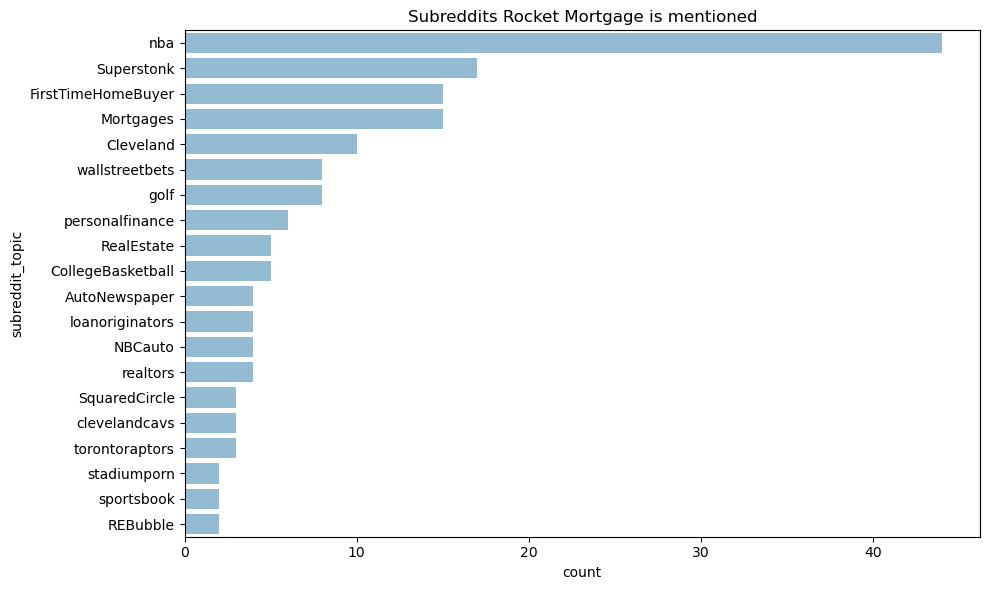

In [9]:
search_query = "Rocket Mortgage"

rkt_df, rkt_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)


In [10]:
# Investigate subbreddit
# check_values_in_subreddit_topic(rkt_df,subreddit_topic= 'loanoriginators') 


In [11]:
# Get the top subreddit topics 
list(rkt_grouped.head(15)['subreddit_topic'])

['nba',
 'Superstonk',
 'FirstTimeHomeBuyer',
 'Mortgages',
 'Cleveland',
 'wallstreetbets',
 'golf',
 'personalfinance',
 'RealEstate',
 'CollegeBasketball',
 'AutoNewspaper',
 'loanoriginators',
 'NBCauto',
 'realtors',
 'SquaredCircle']

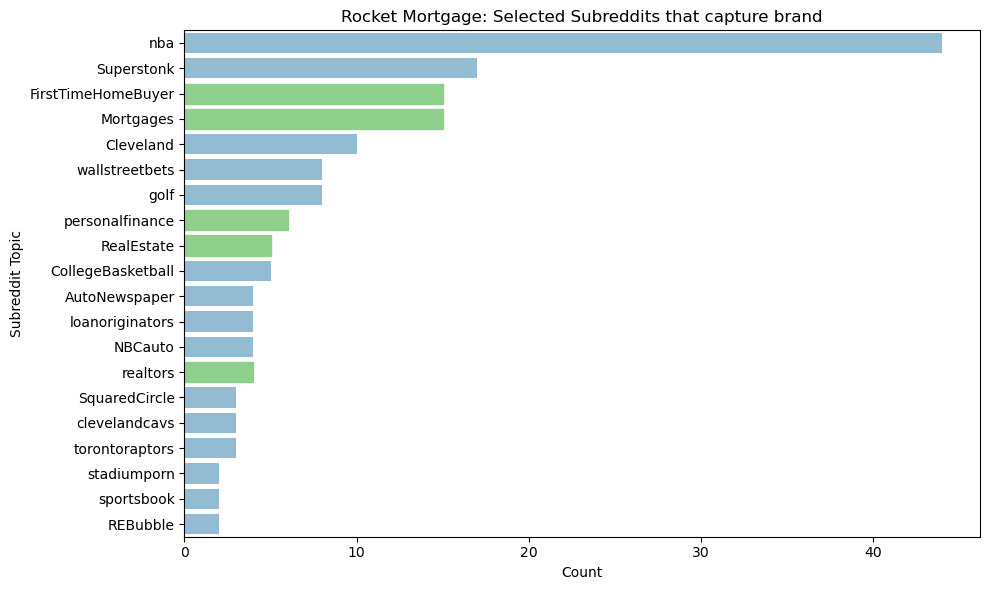

In [12]:
# Selected subreddits
rkt_highlighted_subreddits = ['FirstTimeHomeBuyer', 'Mortgages', 'personalfinance', 'RealEstate', 'realtors']
highlight_visuals(rkt_grouped , highlight_subreddits=rkt_highlighted_subreddits, normalize_setting=False)


## United Wholesale Mortgage (UWM)

Number of records: 231


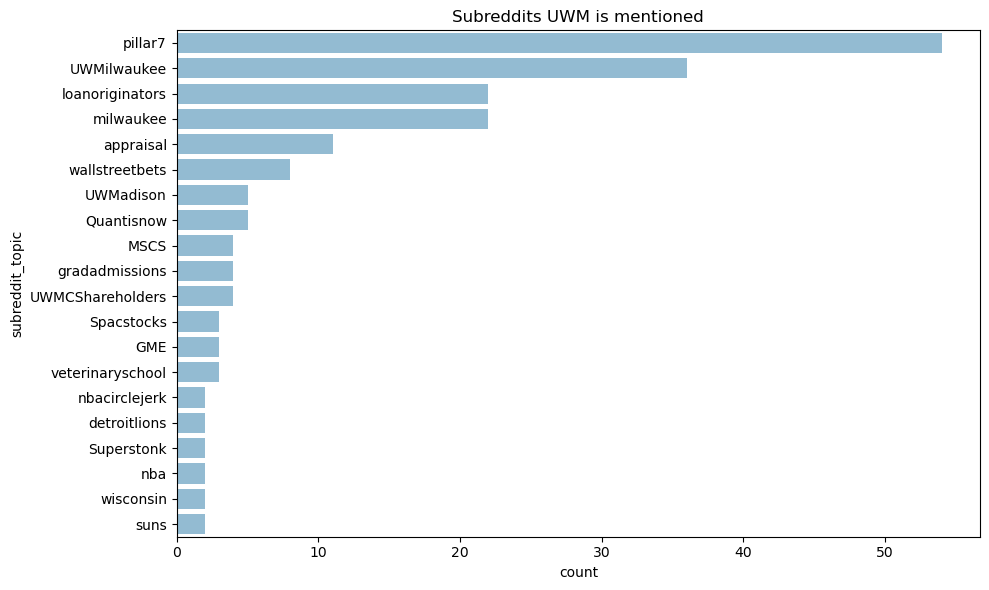

In [13]:
search_query = "UWM"
uwm_df, uwm_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)

In [14]:
# Investigate subbreddit
# check_values_in_subreddit_topic(uwm_df,subreddit_topic= 'Spacstocks') 


In [15]:
# Get the top subreddit topics 
list(uwm_grouped.head(15)['subreddit_topic'])

['pillar7',
 'UWMilwaukee',
 'loanoriginators',
 'milwaukee',
 'appraisal',
 'wallstreetbets',
 'UWMadison',
 'Quantisnow',
 'MSCS',
 'gradadmissions',
 'UWMCShareholders',
 'Spacstocks',
 'GME',
 'veterinaryschool',
 'nbacirclejerk']

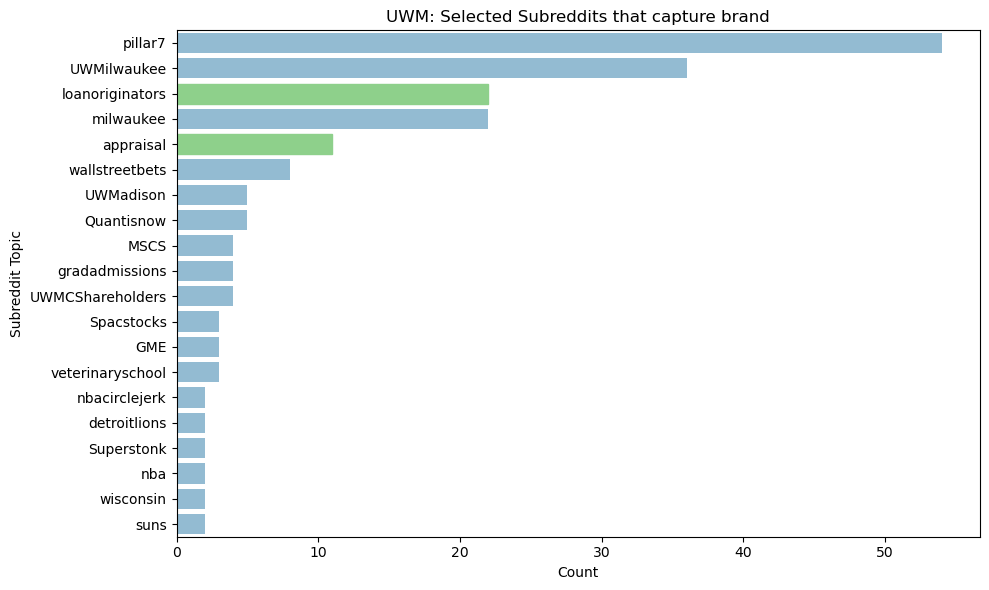

In [16]:
# Selected subreddits
uwm_highlighted_subreddits = ['loanoriginators', 'appraisal']
highlight_visuals(uwm_grouped , highlight_subreddits=uwm_highlighted_subreddits, normalize_setting=False)


## Loan Depot

Number of records: 230


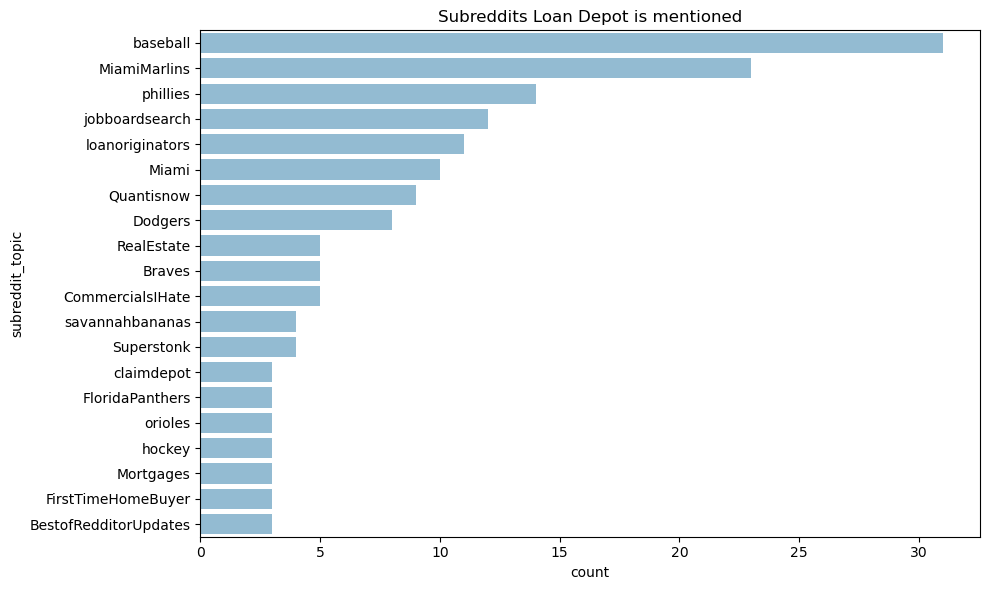

In [17]:
search_query = "Loan Depot"
loan_depot_df, loan_depot_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)


In [18]:
# Investigate subbreddit
# check_values_in_subreddit_topic(loan_depot_df,subreddit_topic= 'loanoriginators') 


In [19]:
# Get the top subreddit topics 
list(loan_depot_grouped.head(20)['subreddit_topic'])

['baseball',
 'MiamiMarlins',
 'phillies',
 'jobboardsearch',
 'loanoriginators',
 'Miami',
 'Quantisnow',
 'Dodgers',
 'RealEstate',
 'Braves',
 'CommercialsIHate',
 'savannahbananas',
 'Superstonk',
 'claimdepot',
 'FloridaPanthers',
 'orioles',
 'hockey',
 'Mortgages',
 'FirstTimeHomeBuyer',
 'BestofRedditorUpdates']

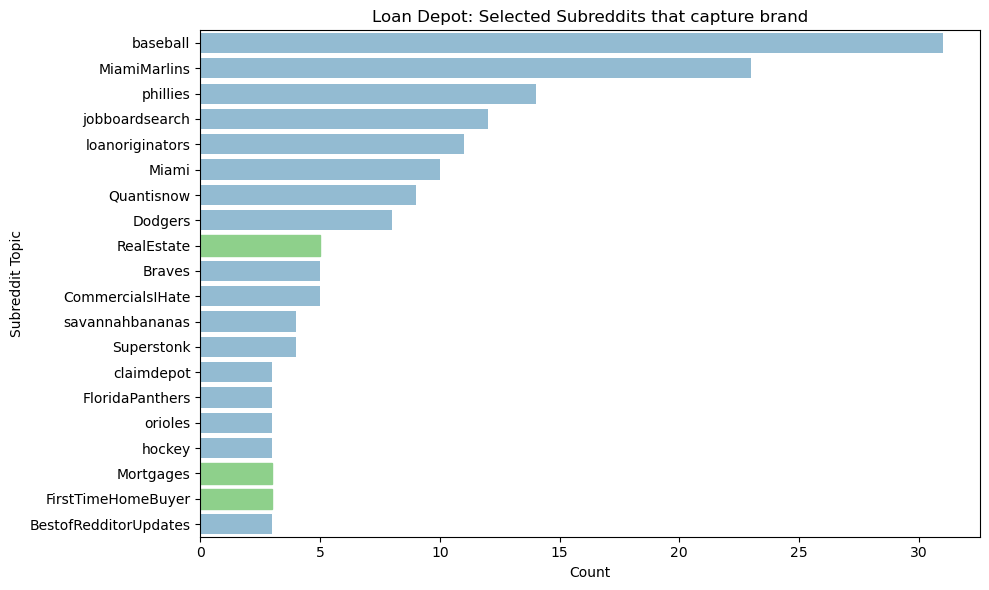

In [20]:
# Selected subreddits
loan_depot_highlighted_subreddits = ['RealEstate', 'Mortgages', 'FirstTimeHomeBuyer']
highlight_visuals(loan_depot_grouped , highlight_subreddits=loan_depot_highlighted_subreddits, normalize_setting=False)


## Xfinity 

Number of records: 199


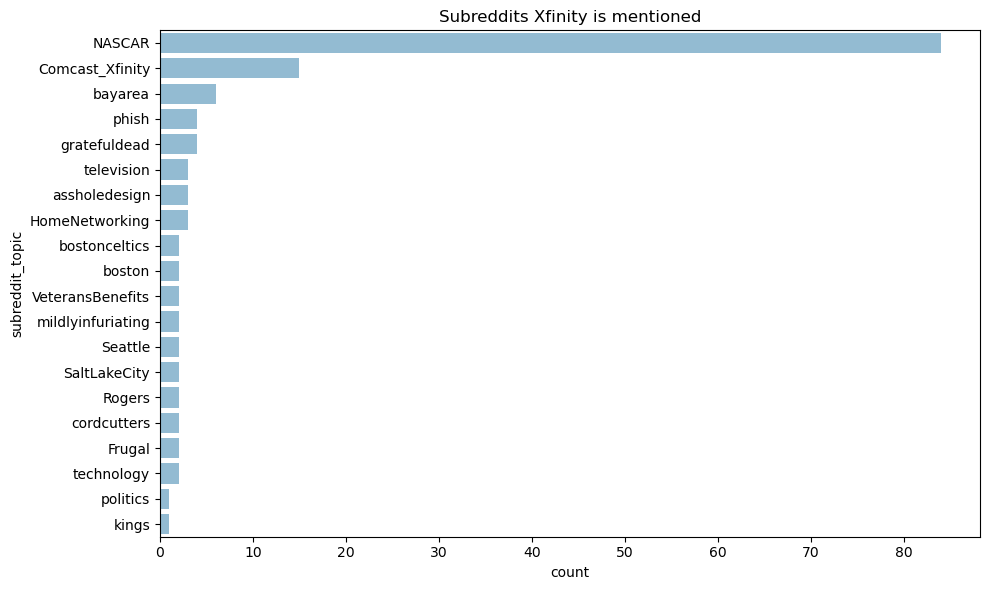

In [21]:
search_query = "Xfinity"
xfinity_df, xfinity_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)

In [22]:
# Investigate subbreddit
# check_values_in_subreddit_topic(xfinity_df,subreddit_topic= 'loanoriginators') 


In [23]:
# Get the top subreddit topics 
list(xfinity_grouped.head(20)['subreddit_topic'])

['NASCAR',
 'Comcast_Xfinity',
 'bayarea',
 'phish',
 'gratefuldead',
 'television',
 'assholedesign',
 'HomeNetworking',
 'bostonceltics',
 'boston',
 'VeteransBenefits',
 'mildlyinfuriating',
 'Seattle',
 'SaltLakeCity',
 'Rogers',
 'cordcutters',
 'Frugal',
 'technology',
 'politics',
 'kings']

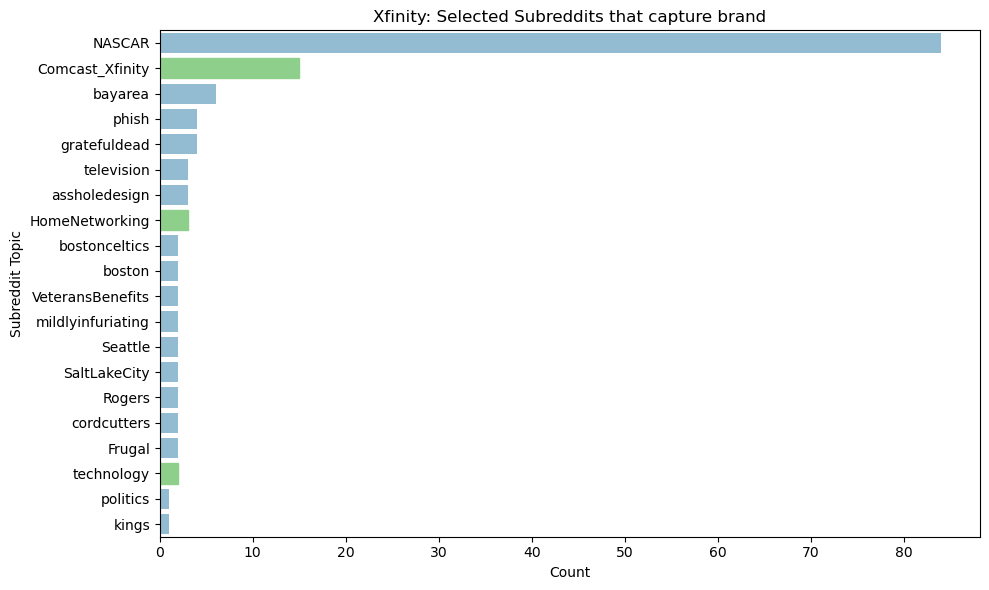

In [24]:
# Selected subreddits
xfinity_highlighted_subreddits = ['Comcast_Xfinity', 'HomeNetworking',  'technology']
highlight_visuals(xfinity_grouped , highlight_subreddits=xfinity_highlighted_subreddits, normalize_setting=False)


## Turbo Tax 

Number of records: 185


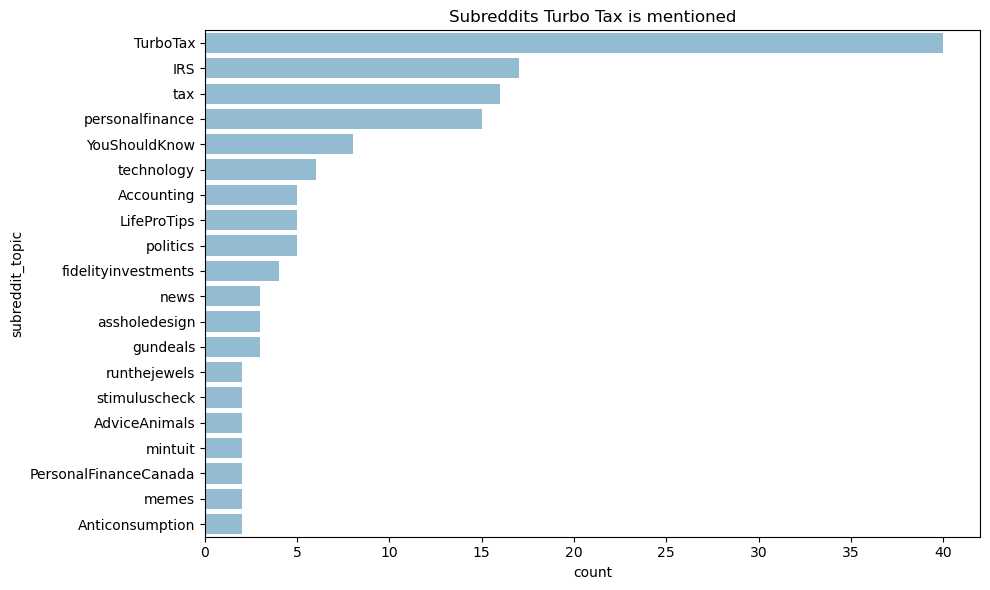

In [25]:
search_query = "Turbo Tax"
turbo_tax_df, turbo_tax_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)


In [26]:
# Investigate subbreddit
# check_values_in_subreddit_topic(turbo_tax_df,subreddit_topic= 'loanoriginators') 


In [27]:
# Get the top subreddit topics 
list(turbo_tax_grouped.head(15)['subreddit_topic'])

['TurboTax',
 'IRS',
 'tax',
 'personalfinance',
 'YouShouldKnow',
 'technology',
 'Accounting',
 'LifeProTips',
 'politics',
 'fidelityinvestments',
 'news',
 'assholedesign',
 'gundeals',
 'runthejewels',
 'stimuluscheck']

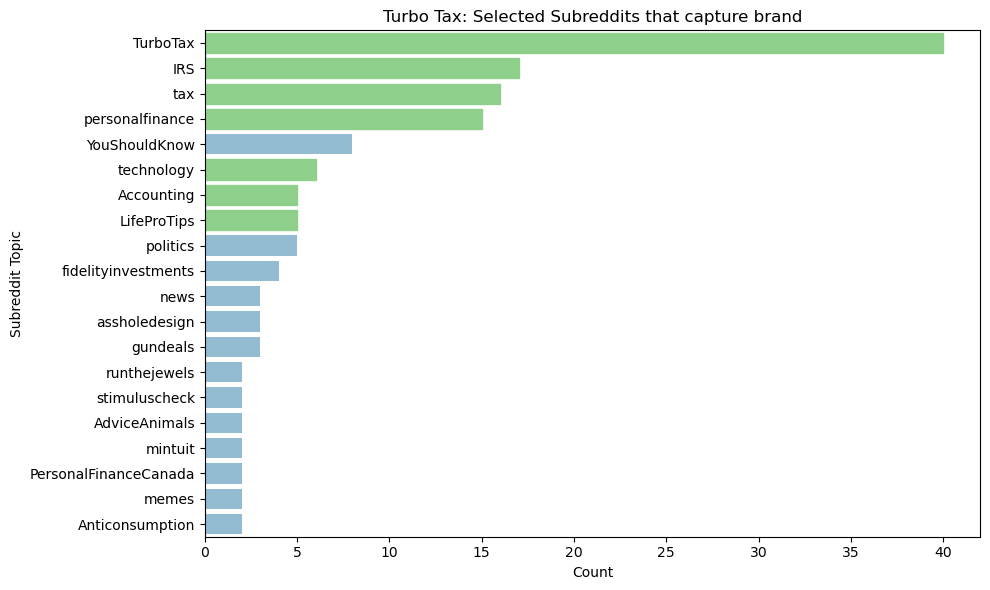

In [28]:
# Selected subreddits
turbo_tax_highlighted_subreddits = ['TurboTax', 'IRS',  'tax', 'personalfinance', 'technology', 'Accounting', 'LifeProTips']
highlight_visuals(turbo_tax_grouped , highlight_subreddits=turbo_tax_highlighted_subreddits, normalize_setting=False)


## Wells Fargo 

Number of records: 141


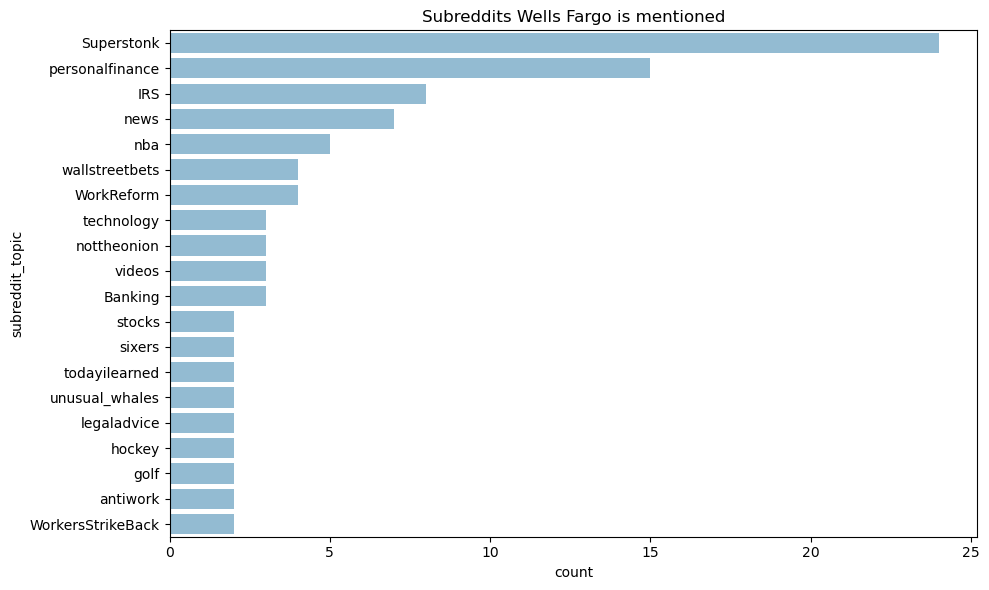

In [29]:
search_query = "Wells Fargo"
wf_df, wf_grouped = create_visuals(search_query_input = search_query, normalize_setting=False)


In [30]:
# Investigate subbreddit
# check_values_in_subreddit_topic(wf_df,subreddit_topic= 'personalfinance') 


In [31]:
# Get the top subreddit topics 
list(wf_grouped.head(15)['subreddit_topic'])

['Superstonk',
 'personalfinance',
 'IRS',
 'news',
 'nba',
 'wallstreetbets',
 'WorkReform',
 'technology',
 'nottheonion',
 'videos',
 'Banking',
 'stocks',
 'sixers',
 'todayilearned',
 'unusual_whales']

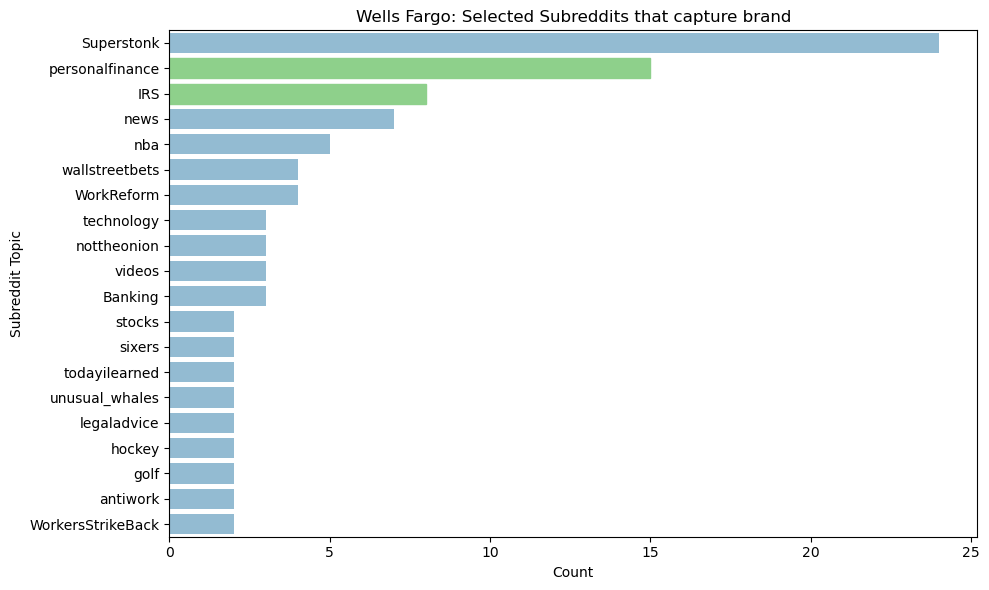

In [32]:
# Selected subreddits
wf_highlighted_subreddits = ['personalfinance', 'IRS']
highlight_visuals(wf_grouped , highlight_subreddits=wf_highlighted_subreddits, normalize_setting=False)


## Output to JSON 

This will output the selected reddits within each brand

In [42]:
final_output = {
    'Rocket Mortgage': rkt_highlighted_subreddits,
    'UWM': uwm_highlighted_subreddits,
    'Loan Depot': loan_depot_highlighted_subreddits,
    'Xfinity': xfinity_highlighted_subreddits,
    'Turbo Tax': turbo_tax_highlighted_subreddits,
    'Wells Fargo': wf_highlighted_subreddits}

In [43]:
final_output

{'Rocket Mortgage': ['FirstTimeHomeBuyer',
  'Mortgages',
  'personalfinance',
  'RealEstate',
  'realtors'],
 'UWM': ['loanoriginators', 'appraisal'],
 'Loan Depot': ['RealEstate', 'Mortgages', 'FirstTimeHomeBuyer'],
 'Xfinity': ['Comcast_Xfinity', 'HomeNetworking', 'technology'],
 'Turbo Tax': ['TurboTax',
  'IRS',
  'tax',
  'personalfinance',
  'technology',
  'Accounting',
  'LifeProTips'],
 'Wells Fargo': ['personalfinance', 'IRS']}

In [44]:
import json
with open('brand_subreddit_config.json', 'w') as f:
    json.dump(final_output, f)